# Imports

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.optimizers import Adam

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from resnets_utils import *
from resnet import *

Using TensorFlow backend.


# Building the ResNet model (50 layers)

In [2]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(16, (5, 5), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [16, 16, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [16, 16, 64], stage=2, block='b')
    X = identity_block(X, 3, [16, 16, 64], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [32, 32, 128], stage=3, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=3, block='c')
    X = identity_block(X, 3, [32, 32, 128], stage=3, block='d')


    # Stage 4
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=4, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=4, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=4, block='d')
    X = identity_block(X, 3, [64, 64, 256], stage=4, block='e')
    X = identity_block(X, 3, [64, 64, 256], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=5, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# The model (47 Simpsons characters classes)

In [3]:
K.clear_session()

model = ResNet50(input_shape = (64, 64, 3), classes = 47)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 33, 33, 16)   1216        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 33, 33, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Define training callbacks

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
#call backs
weights_file = './model.h5'

earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-4, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=40, verbose=1, epsilon=1e-4, mode='min')
model_chk = ModelCheckpoint(monitor='val_loss', filepath=weights_file, save_best_only=True, 
                            save_weights_only=True, mode='min')
        
callbacks = [earlystop, reduce_lr_loss, model_chk, TensorBoard(log_dir='./logs')]

# Compile the model

In [16]:
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.002), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Training and testing from file

In [17]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64

train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory(
        './datasets/training',
        target_size=(64, 64),
        batch_size=batch_size)

testing_set = test_datagen.flow_from_directory(
        './datasets/testing',
        target_size=(64, 64),
        batch_size=batch_size)

Found 20933 images belonging to 47 classes.
Found 940 images belonging to 47 classes.


# Fit the model

In [18]:
training_steps = int(20933)/batch_size
testing_steps = int(940)/batch_size
epochs = 500


model.fit_generator(
        training_set, steps_per_epoch=training_steps,
        epochs=500, verbose=1, callbacks=callbacks,
        validation_data=testing_set, validation_steps=testing_steps)

Epoch 1/500
328/327 [==============================] - 71s 215ms/step - loss: 1.3433 - acc: 0.6274 - val_loss: 2.1010 - val_acc: 0.5532
Epoch 2/500
328/327 [==============================] - 69s 210ms/step - loss: 0.9769 - acc: 0.7229 - val_loss: 0.7935 - val_acc: 0.7511
Epoch 3/500
328/327 [==============================] - 225s 686ms/step - loss: 0.7235 - acc: 0.7916 - val_loss: 0.5661 - val_acc: 0.8436
Epoch 4/500
328/327 [==============================] - 257s 783ms/step - loss: 0.5550 - acc: 0.8425 - val_loss: 0.3930 - val_acc: 0.9021
Epoch 5/500
328/327 [==============================] - 255s 779ms/step - loss: 0.4117 - acc: 0.8829 - val_loss: 0.3120 - val_acc: 0.9191
Epoch 6/500
328/327 [==============================] - 254s 776ms/step - loss: 0.2891 - acc: 0.9183 - val_loss: 0.4063 - val_acc: 0.8713
Epoch 7/500
328/327 [==============================] - 255s 777ms/step - loss: 0.2082 - acc: 0.9414 - val_loss: 0.3365 - val_acc: 0.8926
Epoch 8/500
328/327 [======================

KeyboardInterrupt: 

# Evaluate the model

In [22]:
from keras.models import load_model
model.load_weights('model.h5')

# Training
print(model.evaluate_generator(training_set, steps=training_steps))
# Testing
print(model.evaluate_generator(testing_set, steps=testing_steps))

[0.0012174971721438718, 0.99980891415468398]
[0.0014363411962589685, 1.0]


# Make a prediction from a complete different distribution!

In [70]:
import numpy as np
from keras.preprocessing import image
from IPython.display import Image
import IPython.display

def make_prediction(file):
    test_image = image.load_img(file, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    classes = training_set.class_indices
    predicted_class = list(classes.keys())[list(classes.values()).index(result.argmax())]
    
    print("The predicted class is:", predicted_class)
    display(Image(filename=file, width=256, height=256))

The predicted class is: homer_simpson


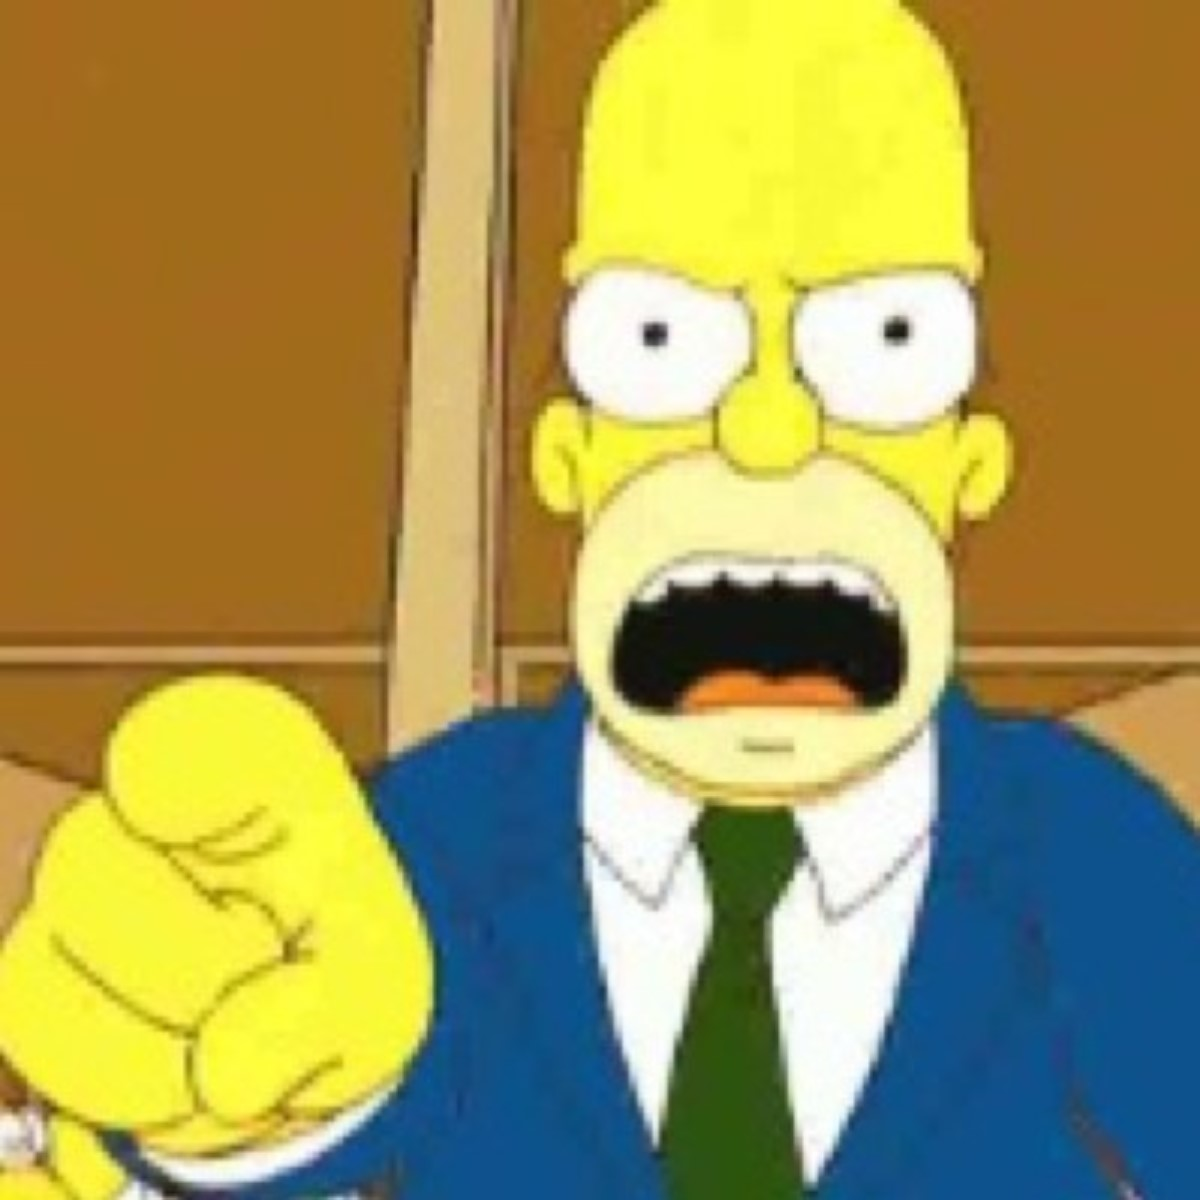

In [71]:
make_prediction('images/image1.png')

The predicted class is: apu_nahasapeemapetilon


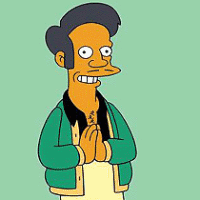

In [72]:
make_prediction('images/image2.jpg')

The predicted class is: lisa_simpson


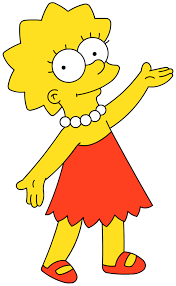

In [73]:
make_prediction('images/image3.png')

# A more ambitious test
### And it did an amazing job!

The predicted class is: lisa_simpson


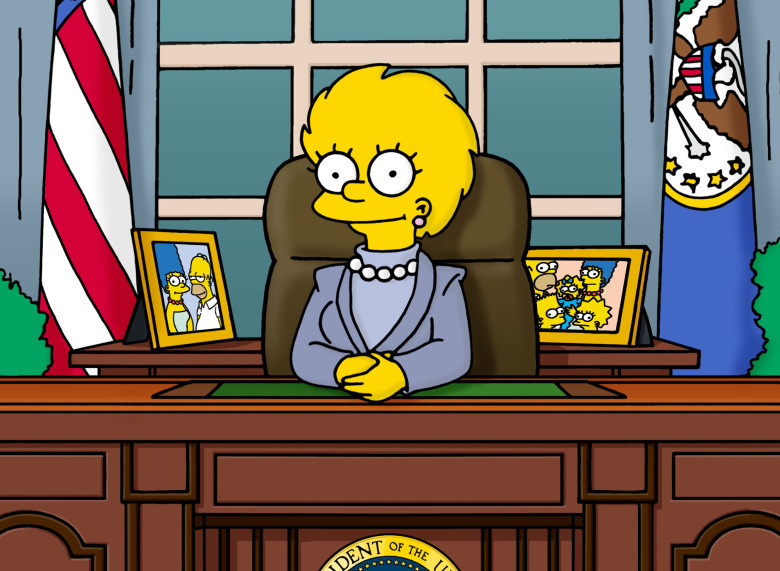

In [74]:
make_prediction('images/image3.jpg')

# Some other tests...

The predicted class is: comic_book_guy


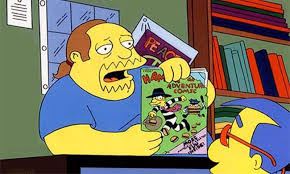

In [75]:
make_prediction('images/image4.jpg')

# ..and the end!

The predicted class is: bart_simpson


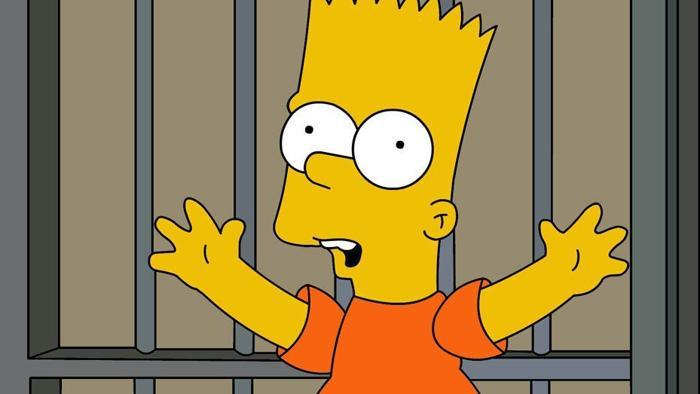

In [76]:
make_prediction('images/image5.png')

# Thank you!